## 0. Run on GPU and Mount google drive.

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Import Libraries

In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from PIL import Image, ImageOps
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import Input
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.random import normal
import glob
import matplotlib.pyplot as plt

%matplotlib inline

## 2. Read data


### 2.1. Read labels of training data from csv file.

In [ ]:
train_data = pd.read_csv("/content/drive/MyDrive/images_train/data.csv")

train_data.head()

,id,values
0,0,oō
1,1,oö
2,2,eê
3,3,oó
4,4,ii


### 2.2. Correct the label of the first image, as it is wronlgy labeled.

In [ ]:
train_data.loc[0, "values"] = "oo"
train_data.head(3)

,id,values
0,0,oo
1,1,oö
2,2,eê


In [ ]:
print("data.csv")
print("Trainset data dimensions: {}".format(train_data.shape))

data.csv
Trainset data dimensions: (2000, 2)


### 2.3. One hot encode the labels.

- Give the letters with corresponding number in order to train model.

- Apply "one_hot" to get the corresponding one hot vectors.

In [ ]:
le = preprocessing.LabelEncoder()
train_data["label"] = le.fit_transform(train_data['values'])
labels = train_data["label"].to_list()
n_classes = len(train_data["values"].unique())

indices = labels
depth = n_classes
labels = tf.one_hot(indices, depth, on_value=1.0, off_value=0.0)

### 2.4. Create tensorflow dataset from images and ohe labels

In [ ]:
im_dir = '/content/drive/MyDrive/images_train/'

ext = ['png'] # Multiple images' formats accepted

files = []
[files.extend(glob.glob(im_dir + '*.' + e)) for e in ext]
files.sort()

filenames = tf.constant(files)
len_data = len(train_data['id'])

dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))

## 3. Preprocess images

### 3.1. Crop and cast to float
- To normalize the values of the pixels we divide all values in the image by 255.

In [ ]:
def _parse_function(filename, label):
    image_string = tf.io.read_file(filename)
    image_decoded = tf.image.decode_png(image_string, channels=3)
    image_cropped = tf.image.crop_to_bounding_box(
        image_decoded, 35, 56, 80, 72
    )
    image = tf.cast(image_cropped, tf.float32) / 255
    
    return image, label

dataset = dataset.map(_parse_function)
dataset = dataset.batch(len_data)

iterator = iter(dataset)
images, labels = iterator.get_next()

### 3.2. The next cell shows some examples of first preprocessing result.

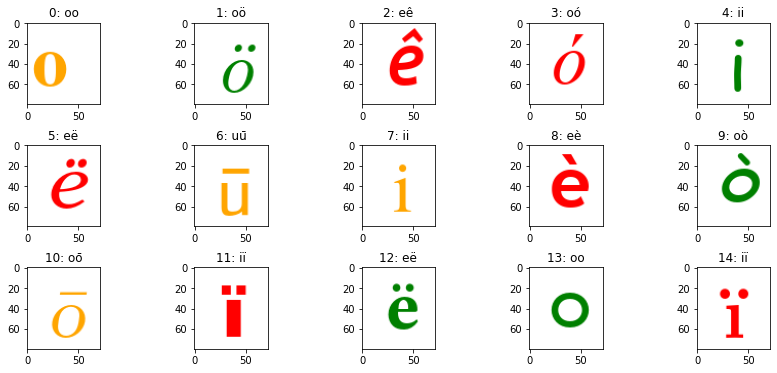

In [ ]:
def print_examples(x, df):
    fig, axs = plt.subplots(3, 5, figsize=(15, 6))
    fig.subplots_adjust(hspace = .5, wspace=.001)

    axs = axs.ravel()

    for i in range(15):
        axs[i].imshow(x[i])
        axs[i].set_title(f"{i}: {df.loc[i, 'values']}")
    
print_examples(images, train_data)

### 3.3. Transform the images to grayscale.

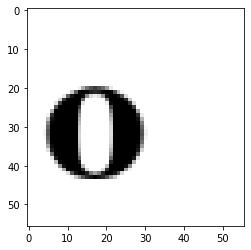

In [ ]:
gray_images = tf.image.rgb_to_grayscale(images)
gray_images = tf.image.resize(gray_images, [56,56])
plt.imshow(gray_images[0].numpy().squeeze(axis=2), cmap='gray')

shape = tf.shape(gray_images[0])

In [ ]:
print(tf.shape(gray_images[0]))

tf.Tensor([56 56  1], shape=(3,), dtype=int32)


### 3.4. Data augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.05),
    # layers.RandomFlip(mode="horizontal_and_vertical"),
    # layers.RandomFlip(mode="horizontal"), 
    layers.RandomZoom(
        height_factor=(-0.3, 0),
        width_factor=(-0.3, 0),
        seed=42,
    ), 
    # layers.GaussianNoise(stddev=0.01, seed=None)
])

aug_images = tf.concat([gray_images, data_augmentation(gray_images, training = True)], 0)
labels_long = tf.concat([labels, labels], 0)
data_len = len(labels_long)

aug_images_1 = tf.concat([aug_images, data_augmentation(aug_images, training = True)], 0)
labels_long_long = tf.concat([labels_long, labels_long], 0)
data_len = len(labels_long_long)

# aug_ds = tf.data.Dataset.from_tensor_slices((aug_images_1, labels_long_long))
# aug_ds = aug_ds.shuffle(data_len, reshuffle_each_iteration=True)

## 4. Experiments

### 4.1. Create a model

In [ ]:
# without aug
def create_model_small_without_aug():
  model = tf.keras.Sequential()

  model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding='same', input_shape=gray_images.shape[1:]))
  model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding='same'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(tf.keras.layers.Dropout(rate=0.25))
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(512, activation="relu"))
  model.add(tf.keras.layers.Dropout(rate=0.5))
  model.add(tf.keras.layers.Dense(128, activation="relu"))
  model.add(tf.keras.layers.Dropout(rate=0.5))
  model.add(tf.keras.layers.Dense(30, activation="softmax"))

  model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

  return model

In [ ]:
# with aug
def create_model_big_with_aug():
  model = tf.keras.Sequential()

  model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding='same', input_shape=aug_images_1.shape[1:]))
  model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding='same'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(tf.keras.layers.Dropout(rate=0.25))
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(512, activation="relu"))
  model.add(tf.keras.layers.Dropout(rate=0.5))
  model.add(tf.keras.layers.Dense(128, activation="relu"))
  model.add(tf.keras.layers.Dropout(rate=0.5))
  model.add(tf.keras.layers.Dense(30, activation="softmax"))

  model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

  return model

In [ ]:
validation_size = 0.2
batch_size = 50
epochs = 300

model_small = create_model_small_without_aug()
model_big = create_model_big_with_aug()

In [ ]:
model_small.summary(line_length=None, positions=None, print_fn=None)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 56, 56, 32)        320       
                                                                 
 conv2d_15 (Conv2D)          (None, 56, 56, 32)        9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 28, 28, 32)       0         
 2D)                                                             
                                                                 
 dropout_21 (Dropout)        (None, 28, 28, 32)        0         
                                                                 
 flatten_7 (Flatten)         (None, 25088)             0         
                                                                 
 dense_21 (Dense)            (None, 512)               12845568  
                                                     

In [ ]:
model_big.summary(line_length=None, positions=None, print_fn=None)

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 56, 56, 32)        320       
                                                                 
 conv2d_25 (Conv2D)          (None, 56, 56, 32)        9248      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 28, 28, 32)       0         
 g2D)                                                            
                                                                 
 dropout_36 (Dropout)        (None, 28, 28, 32)        0         
                                                                 
 flatten_12 (Flatten)        (None, 25088)             0         
                                                                 
 dense_36 (Dense)            (None, 512)               12845568  
                                                     

### 4.2. Train models
- Now we train a convolutional neural network using Conv2D layers and connected neural network.

In [ ]:
# without aug
history_small = model_small.fit(gray_images, labels, validation_split=validation_size, batch_size=batch_size, epochs=epochs)

In [ ]:
# with aug
history_big = model_big.fit(aug_images_1, labels_long_long, validation_split=validation_size, batch_size=batch_size, epochs=epochs)

Epoch 1/300
128/128 [==============================] - 5s 32ms/step - loss: 3.3621 - accuracy: 0.0506 - val_loss: 3.0924 - val_accuracy: 0.1187
Epoch 2/300
128/128 [==============================] - 4s 30ms/step - loss: 2.7844 - accuracy: 0.1533 - val_loss: 2.4211 - val_accuracy: 0.2556
Epoch 3/300
128/128 [==============================] - 4s 29ms/step - loss: 2.1637 - accuracy: 0.2970 - val_loss: 2.0549 - val_accuracy: 0.3344
Epoch 4/300
128/128 [==============================] - 4s 29ms/step - loss: 1.7105 - accuracy: 0.4273 - val_loss: 1.7916 - val_accuracy: 0.4325
Epoch 5/300
128/128 [==============================] - 4s 29ms/step - loss: 1.3606 - accuracy: 0.5311 - val_loss: 1.5118 - val_accuracy: 0.5175
Epoch 6/300
128/128 [==============================] - 4s 29ms/step - loss: 1.0839 - accuracy: 0.6230 - val_loss: 1.3589 - val_accuracy: 0.5738
Epoch 7/300
128/128 [==============================] - 4s 29ms/step - loss: 0.9054 - accuracy: 0.6928 - val_loss: 1.2600 - val_accuracy:

## 5. Plot Training history
- Show the plot of accuracy and loss

In [ ]:
def accuracy_plot(history):
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.title("Model accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Train_val", "Test_val"], loc="upper left")
    plt.show()

In [ ]:
def loss_plot(history):
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("Model loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(["Train_loss", "Test_loss"], loc="upper left")
    plt.show()

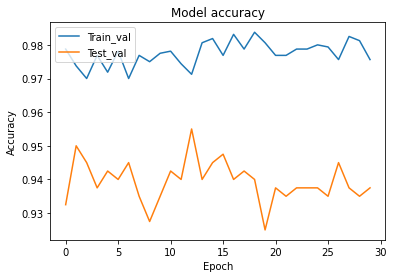

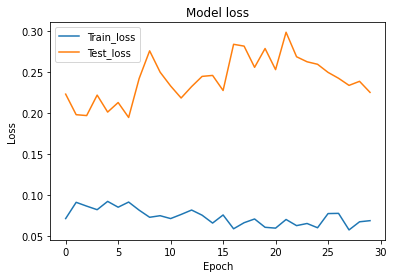

In [ ]:
accuracy_plot(history_small)
loss_plot(history_small)

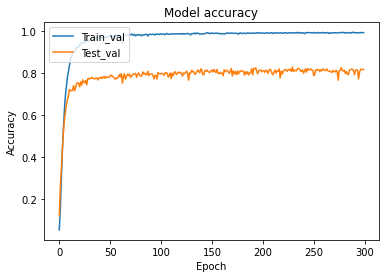

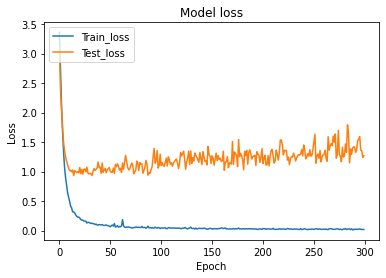

In [ ]:
accuracy_plot(history_big)
loss_plot(history_big)

## 6. Testing
- Since we have used a part of the trainset to do the evaluation, we can now measure the performance of the model on the testset.

In [ ]:
score = model.evaluate(test_images, test_labels)
print("Test loss: {}".format(score[0]))
print("Test accuracy: {}".format(score[1]))

NameError: ignored